In [1]:
import matplotlib.pyplot as plt

In [3]:
import geemap
import ee

# Authenticate and initialize Earth Engine
ee.Authenticate()
ee.Initialize(project='ee-jamessmart22')

# Create a map centered on Kericho County
Map = geemap.Map(center=[-0.2711, 35.5982], zoom=9)
my_county=str(input("Enter your county: "))
# Define the class of interest (e.g., '0' for Tea, '1' for Forest, etc.)
class_of_interest = int(input("Enter the class number you want to calculate the area for: "))
# Define the region of interest (ROI) for Kericho County
roi = ee.FeatureCollection("FAO/GAUL_SIMPLIFIED_500m/2015/level2").filter(ee.Filter.eq("ADM2_NAME", my_county))

# Add ROI to the map
Map.addLayer(roi, {'color': 'red'}, 'Kericho County ROI')

# Prompt the user for start and end years
start_year = int(input("Enter the start year (YYYY): "))
end_year = int(input("Enter the end year (YYYY): "))

# Define your training data (ensure these FeatureCollections have valid samples)
Tea = ee.FeatureCollection('projects/ee-jamessmart22/assets/Tea')
Forest = ee.FeatureCollection('projects/ee-jamessmart22/assets/Forest')
Builtup = ee.FeatureCollection('projects/ee-jamessmart22/assets/Builtup')
OtherAgriculture = ee.FeatureCollection('projects/ee-jamessmart22/assets/Otheragriculture')

# Combine training data
training = Tea.merge(Forest).merge(Builtup).merge(OtherAgriculture)

# Make sure 'class' property exists in your FeatureCollections
label = 'class'
bands = ['B2', 'B3', 'B4', 'B5']

# Initialize lists to store classified images
years = []
classified_images = []

# Loop through each year and classify the images
for year in range(start_year, end_year + 1):
    # Define the date range for the current year
    start_date = f"{year}-01-01"
    end_date = f"{year}-12-31"

    # Load Sentinel-2 image collection and process it
    image = (ee.ImageCollection("LANDSAT/LC08/C02/T1_TOA")
              .filterBounds(roi)
              .filterDate(start_date, end_date)
              .sort("CLOUD_COVER")
              .mosaic()
              .clip(roi))

    # Check if the image has the required bands
    band_names = image.bandNames().getInfo()
    required_bands = all(band in band_names for band in bands)

    if not required_bands:
        print(f"No valid Landsat data with required bands for year {year}. Skipping...")
        continue

    # Sample the input image to generate training data
    trainImage = image.select(bands).sampleRegions(
        collection=training,
        properties=[label],
        scale=30
    )

    # Split the training data into training and testing datasets
    training_data = trainImage.randomColumn()
    train_set = training_data.filter(ee.Filter.lt('random', 0.8))  # 80% for training
    test_set = training_data.filter(ee.Filter.gte('random', 0.8))   # 20% for testing

    # Train a classifier
    if train_set.size().getInfo() > 0 and test_set.size().getInfo():  # Check if there is data to train
        classifier = ee.Classifier.smileRandomForest(100).train(train_set, label, bands)

        # Classify the image
        classified_image = image.select(bands).classify(classifier)
        Map.addLayer(classified_image, {'min': 0, 'max': 3, 'palette': ['#98ff00', '#076416', '#ff4e15', '#8fffba']}, f"Classified {year}")

        # Store the classified image
        classified_images.append(classified_image)
        years.append(year)
        # Accuracy Assessment: Classify the test set
        test_classification = test_set.classify(classifier)

        # Generate the confusion matrix
        confusion_matrix = test_classification.errorMatrix(label, 'classification')

        # Print confusion matrix and accuracy metrics
        class_mask = classified_image.eq(class_of_interest)
        class_area = class_mask.multiply(ee.Image.pixelArea()).reduceRegion(
        reducer=ee.Reducer.sum(),
        geometry=roi.geometry(),
        scale=30,
        maxPixels=1e9
         ).get('classification')

        class_area_sq_km = ee.Number(class_area).divide(1e6).getInfo()
        total_area = 0
        if class_area:
            class_area_sq_km = ee.Number(class_area).divide(1e6).getInfo()
            total_area += class_area_sq_km
            print(f"Area of class {class_of_interest} in {my_county} for year {year}: {class_area_sq_km} sq km")
        else:
            print(f"No data available for class {class_of_interest} in {my_county} for year {year}.")

        print(f"\nAccuracy results for {year}:")
        print("Confusion Matrix:\n", confusion_matrix.getInfo())
        print("Overall Accuracy: ", confusion_matrix.accuracy().getInfo())
        print("Kappa Coefficient: ", confusion_matrix.kappa().getInfo())

    else:
        print(f"Not enough training or testing data to train the classifier for year {year}.")

# Continue with tea change detection and visualization
# The rest of the code remains unchanged...

# Function to compute tea-related changes and assign colors
def compute_tea_change_map(classified_image1, classified_image2):
    # Detect tea-related changes (from or to tea)
    change_map = classified_image1.multiply(10).add(classified_image2)  # Create unique transition codes

    # Define tea transitions and assign specific colors
    tea_palette = {
        0: '#ffffff',   # No change (Tea to Tea)
        10: '#ff0000',  # Tea to Forest
        20: '#00ff00',  # Tea to Built-up
        30: '#0000ff',  # Tea to Other Agriculture
        1: '#ffff00',   # Forest to Tea
        2: '#ff00ff',   # Built-up to Tea
        3: '#00ffff'    # Other Agriculture to Tea
                 }

    # Mask non-tea related changes
    tea_change_map = change_map.mask(
        change_map.eq(10)  # Tea to Forest
        .Or(change_map.eq(20))  # Tea to Built-up
        .Or(change_map.eq(30))  # Tea to Other Agriculture
        .Or(change_map.eq(1))  # Forest to Tea
        .Or(change_map.eq(2))  # Built-up to Tea
        .Or(change_map.eq(3))  # Other Agriculture to Tea
                                   )

    # Visualize the tea changes with the specified colors
    tea_change_visual = tea_change_map.visualize(min=1, max=30, palette=[tea_palette[key] for key in sorted(tea_palette.keys())])

    return tea_change_visual
# Function to calculate areas for tea-related changes
def calculate_tea_change_areas(classified_image1, classified_image2):
    change_map = classified_image1.multiply(10).add(classified_image2)

    # Define areas of interest for each tea-related change
    tea_to_forest = change_map.eq(10)
    tea_to_builtup = change_map.eq(20)
    tea_to_other_agriculture = change_map.eq(30)
    forest_to_tea = change_map.eq(1)
    builtup_to_tea = change_map.eq(2)
    other_agriculture_to_tea = change_map.eq(3)

    # Calculate areas (in square kilometers)
    area_tea_to_forest = tea_to_forest.multiply(ee.Image.pixelArea()).divide(1e6).reduceRegion(
        reducer=ee.Reducer.sum(), geometry=roi, scale=30).get('classification').getInfo()

    area_tea_to_builtup = tea_to_builtup.multiply(ee.Image.pixelArea()).divide(1e6).reduceRegion(
        reducer=ee.Reducer.sum(), geometry=roi, scale=30).get('classification').getInfo()

    area_tea_to_other_agriculture = tea_to_other_agriculture.multiply(ee.Image.pixelArea()).divide(1e6).reduceRegion(
        reducer=ee.Reducer.sum(), geometry=roi, scale=30).get('classification').getInfo()

    area_forest_to_tea = forest_to_tea.multiply(ee.Image.pixelArea()).divide(1e6).reduceRegion(
        reducer=ee.Reducer.sum(), geometry=roi, scale=30).get('classification').getInfo()

    area_builtup_to_tea = builtup_to_tea.multiply(ee.Image.pixelArea()).divide(1e6).reduceRegion(
        reducer=ee.Reducer.sum(), geometry=roi, scale=30).get('classification').getInfo()

    area_other_agriculture_to_tea = other_agriculture_to_tea.multiply(ee.Image.pixelArea()).divide(1e6).reduceRegion(
        reducer=ee.Reducer.sum(), geometry=roi, scale=30).get('classification').getInfo()

    # Print the area results
    print(f"Tea to Forest Area (sq km): {area_tea_to_forest}")
    print(f"Tea to Built-up Area (sq km): {area_tea_to_builtup}")
    print(f"Tea to Other Agriculture Area (sq km): {area_tea_to_other_agriculture}")
    print(f"Forest to Tea Area (sq km): {area_forest_to_tea}")
    print(f"Built-up to Tea Area (sq km): {area_builtup_to_tea}")
    print(f"Other Agriculture to Tea Area (sq km): {area_other_agriculture_to_tea}")

# Visualize tea-related changes between every two consecutive years
for i in range(1, len(classified_images)):
    prev_year = years[i - 1]
    curr_year = years[i]

    # Compute tea-related LULC changes between the two years
    tea_change_visual = compute_tea_change_map(classified_images[i - 1], classified_images[i])

    # Add the tea-related LULC change layer to the map with specific transitions
    Map.addLayer(tea_change_visual, {}, f"Tea LULC Change {prev_year}-{curr_year}")

    # Calculate and print areas of tea-related changes between the two years
    print(f"\nTea-related land cover changes from {prev_year} to {curr_year}:")
    calculate_tea_change_areas(classified_images[i - 1], classified_images[i])

# Function to calculate areas for tea-related changes
def calculate_tea_change_areas(classified_image1, classified_image2):
    change_map = classified_image1.multiply(10).add(classified_image2)

    # Define areas of interest for each tea-related change
    tea_to_forest = change_map.eq(10)
    tea_to_builtup = change_map.eq(20)
    tea_to_other_agriculture = change_map.eq(30)
    forest_to_tea = change_map.eq(1)
    builtup_to_tea = change_map.eq(2)
    other_agriculture_to_tea = change_map.eq(3)

    # Calculate areas (in square kilometers)
    area_tea_to_forest = tea_to_forest.multiply(ee.Image.pixelArea()).divide(1e6).reduceRegion(
        reducer=ee.Reducer.sum(), geometry=roi, scale=30).get('classification').getInfo()

    area_tea_to_builtup = tea_to_builtup.multiply(ee.Image.pixelArea()).divide(1e6).reduceRegion(
        reducer=ee.Reducer.sum(), geometry=roi, scale=30).get('classification').getInfo()

    area_tea_to_other_agriculture = tea_to_other_agriculture.multiply(ee.Image.pixelArea()).divide(1e6).reduceRegion(
        reducer=ee.Reducer.sum(), geometry=roi, scale=30).get('classification').getInfo()

    area_forest_to_tea = forest_to_tea.multiply(ee.Image.pixelArea()).divide(1e6).reduceRegion(
        reducer=ee.Reducer.sum(), geometry=roi, scale=30).get('classification').getInfo()

    area_builtup_to_tea = builtup_to_tea.multiply(ee.Image.pixelArea()).divide(1e6).reduceRegion(
        reducer=ee.Reducer.sum(), geometry=roi, scale=30).get('classification').getInfo()

    area_other_agriculture_to_tea = other_agriculture_to_tea.multiply(ee.Image.pixelArea()).divide(1e6).reduceRegion(
        reducer=ee.Reducer.sum(), geometry=roi, scale=30).get('classification').getInfo()

    # Print the area results
    print(f"Tea to Forest Area (sq km): {area_tea_to_forest}")
    print(f"Tea to Built-up Area (sq km): {area_tea_to_builtup}")
    print(f"Tea to Other Agriculture Area (sq km): {area_tea_to_other_agriculture}")
    print(f"Forest to Tea Area (sq km): {area_forest_to_tea}")
    print(f"Built-up to Tea Area (sq km): {area_builtup_to_tea}")
    print(f"Other Agriculture to Tea Area (sq km): {area_other_agriculture_to_tea}")

# Display the map
Map

# Function to create and add a legend using HTML for tea-related changes
def add_tea_change_legend(map_object):
    legend_html = """
    <div style="position: fixed;
                bottom: 10px;
                left: 10px;
                z-index: 9999;
                font-size: 14px;
                background-color: white;
                padding: 10px;
                border: 2px solid gray;
                border-radius: 5px;">
        <h4>Tea Land Cover Changes</h4>
        <i style="background:#ff0000;width:18px;height:18px;float:left;margin-right:8px;"></i> Tea to Forest<br>
        <i style="background:#00ff00;width:18px;height:18px;float:left;margin-right:8px;"></i> Tea to Built-up<br>
        <i style="background:#0000ff;width:18px;height:18px;float:left;margin-right:8px;"></i> Tea to Other Agriculture<br>
        <i style="background:#ffff00;width:18px;height:18px;float:left;margin-right:8px;"></i> Forest to Tea<br>
        <i style="background:#ff00ff;width:18px;height:18px;float:left;margin-right:8px;"></i> Built-up to Tea<br>
        <i style="background:#00ffff;width:18px;height:18px;float:left;margin-right:8px;"></i> Other Agriculture to Tea<br>
    </div>
    """
    map_object.add_html(legend_html)

# Add the legend to the map
add_tea_change_legend(Map)
Map

Enter your county: Kericho
Enter the class number you want to calculate the area for: 0
Enter the start year (YYYY): 2015
Enter the end year (YYYY): 2024
Area of class 0 in Kericho for year 2015: 1093.7197901919149 sq km

Accuracy results for 2015:
Confusion Matrix:
 [[4, 1, 0, 0], [2, 9, 1, 1], [0, 0, 11, 0], [1, 2, 2, 8]]
Overall Accuracy:  0.7619047619047619
Kappa Coefficient:  0.6774193548387095
Area of class 0 in Kericho for year 2016: 681.7588883539124 sq km

Accuracy results for 2016:
Confusion Matrix:
 [[8, 3, 2, 1], [1, 9, 1, 1], [3, 2, 5, 0], [2, 1, 0, 9]]
Overall Accuracy:  0.6458333333333334
Kappa Coefficient:  0.5244755244755245
Area of class 0 in Kericho for year 2017: 701.6203984542575 sq km

Accuracy results for 2017:
Confusion Matrix:
 [[6, 0, 0, 1], [0, 13, 0, 0], [0, 0, 13, 0], [1, 0, 0, 4]]
Overall Accuracy:  0.9473684210526315
Kappa Coefficient:  0.9263565891472866
Area of class 0 in Kericho for year 2018: 335.9880669714036 sq km

Accuracy results for 2018:
Confusi

Map(center=[-0.2711, 35.5982], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDa…

**<h1>Graphs for individual classes</h1>**

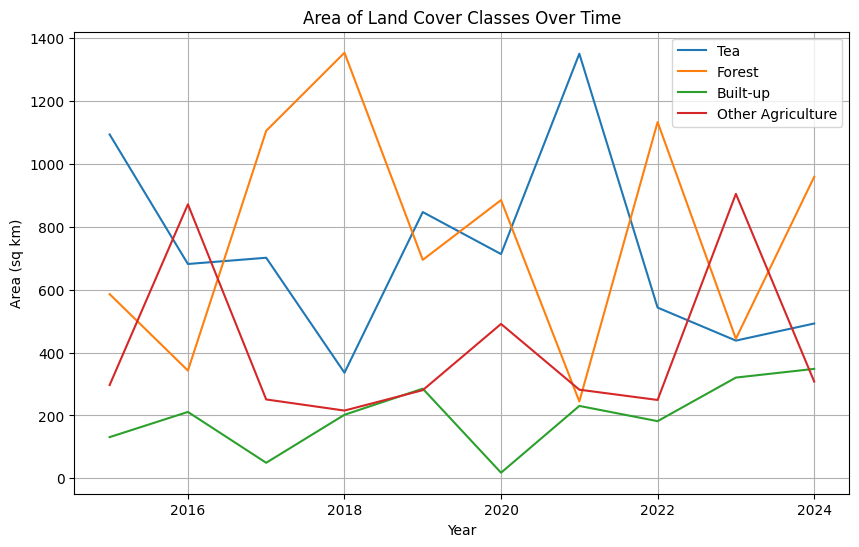

In [5]:

import matplotlib.pyplot as plt

# Function to calculate area of individual classes
def calculate_class_area(classified_image, roi, class_value):
    class_mask = classified_image.eq(class_value)
    class_area = class_mask.multiply(ee.Image.pixelArea()).reduceRegion(
        reducer=ee.Reducer.sum(),
        geometry=roi.geometry(),
        scale=30,
        maxPixels=1e9
    ).get('classification')
    return ee.Number(class_area).divide(1e6).getInfo()  # Convert to sq km

# List of classes and class labels
class_labels = {0: "Tea", 1: "Forest", 2: "Built-up", 3: "Other Agriculture"}

# Store the results for each class
class_areas = {class_label: [] for class_label in class_labels.values()}
years_list = []

# Loop through classified images and calculate area for each class
for i in range(len(classified_images)):
    current_year = years[i]
    years_list.append(current_year)

    # Calculate and store areas for each class
    for class_value, class_name in class_labels.items():
        area = calculate_class_area(classified_images[i], roi, class_value)
        class_areas[class_name].append(area)

# Plot the area of individual classes over time
plt.figure(figsize=(10, 6))
for class_name, areas in class_areas.items():
    plt.plot(years_list, areas, label=class_name)

plt.xlabel('Year')
plt.ylabel('Area (sq km)')
plt.title('Area of Land Cover Classes Over Time')
plt.legend()
plt.grid(True)
plt.show()


**<h1>Charts for individual classes</h1>**

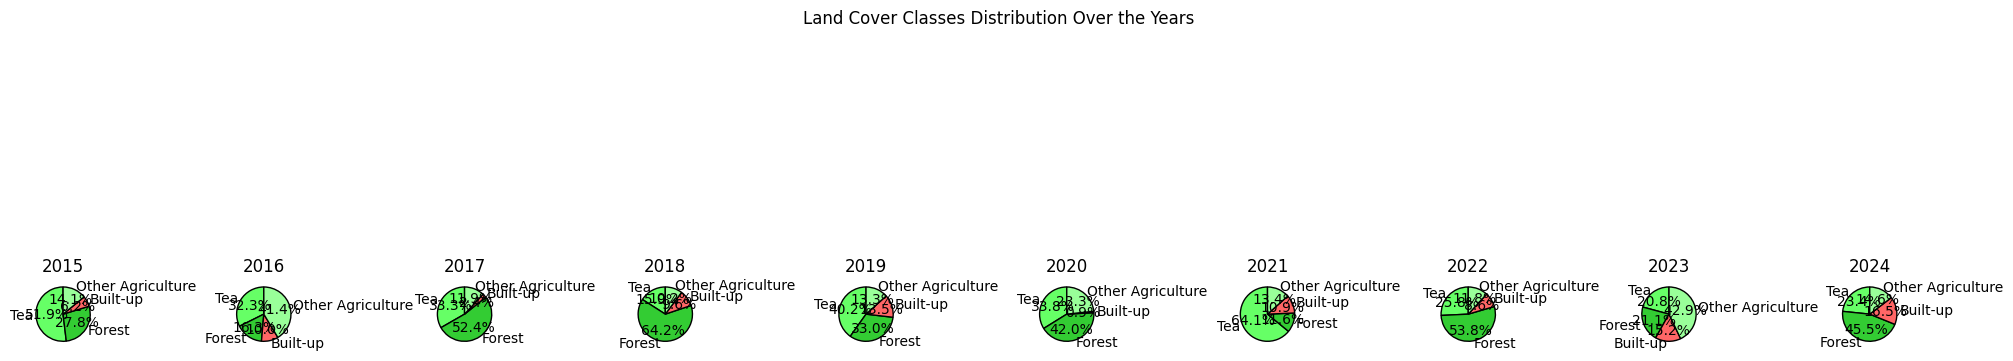

In [6]:
import matplotlib.pyplot as plt

# Define colors with green shades for Tea, Forest, Other Agriculture and red for Built-up
class_colors = {
    'Tea': '#66ff66',              # Light green
    'Forest': '#33cc33',           # Medium green
    'Other Agriculture': '#99ff99',# Pale green
    'Built-up': '#ff6666'          # Red
}

# Create subplots for each year, with 4 pie charts in one row
fig, axs = plt.subplots(1, len(years), figsize=(20, 6))

# Loop through the years and create a pie chart for each
for i, year in enumerate(years):
    # Values (areas) for the current year
    areas = [class_areas['Tea'][i], class_areas['Forest'][i], class_areas['Built-up'][i], class_areas['Other Agriculture'][i]]

    # Corresponding labels and colors
    labels = ['Tea', 'Forest', 'Built-up', 'Other Agriculture']
    colors = [class_colors[label] for label in labels]

    # Create pie chart in the corresponding subplot
    axs[i].pie(areas, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90, wedgeprops={'edgecolor': 'black'})
    axs[i].set_title(str(year))

# Set a global title
plt.suptitle('Land Cover Classes Distribution Over the Years')

# Show the plot
plt.tight_layout()
plt.show()
